# MultiDVPS: Depth-Aware Video Panoptic Segmentation

This notebook demonstrates the use of the MultiDVPS model. We start by loading some checkpoint, then visualize aspects
of the outputs during both traning and inference.

2023-11-23 16:50:28 📝 unipercept.data  : Wrapping dataset: CityscapesDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='train', root='//datasets/cityscapes')
2023-11-23 16:50:29 📝 unipercept.data  : Wrapping dataset: CityscapesDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='train', root='//datasets/cityscapes')


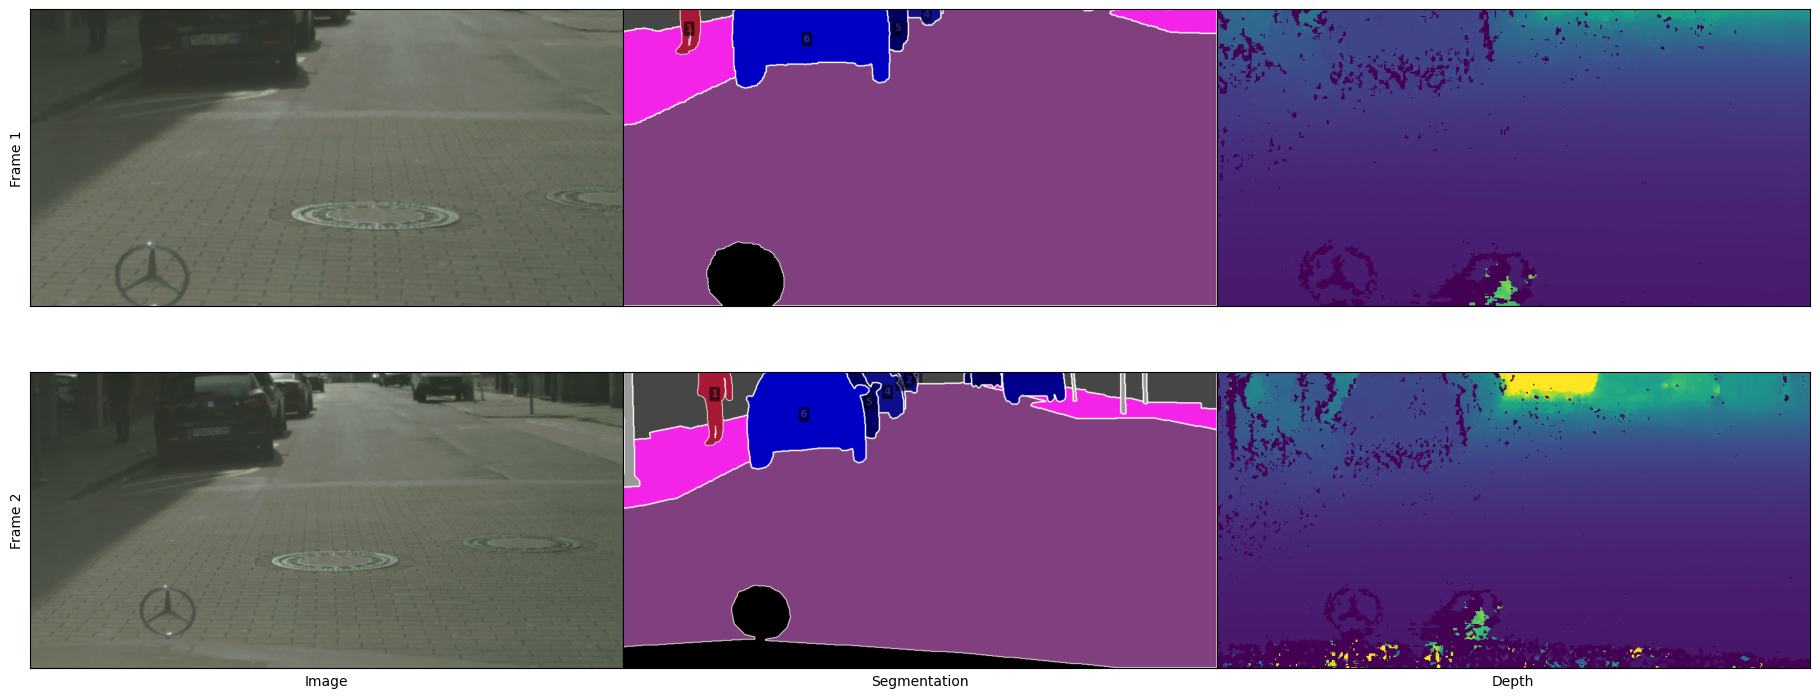

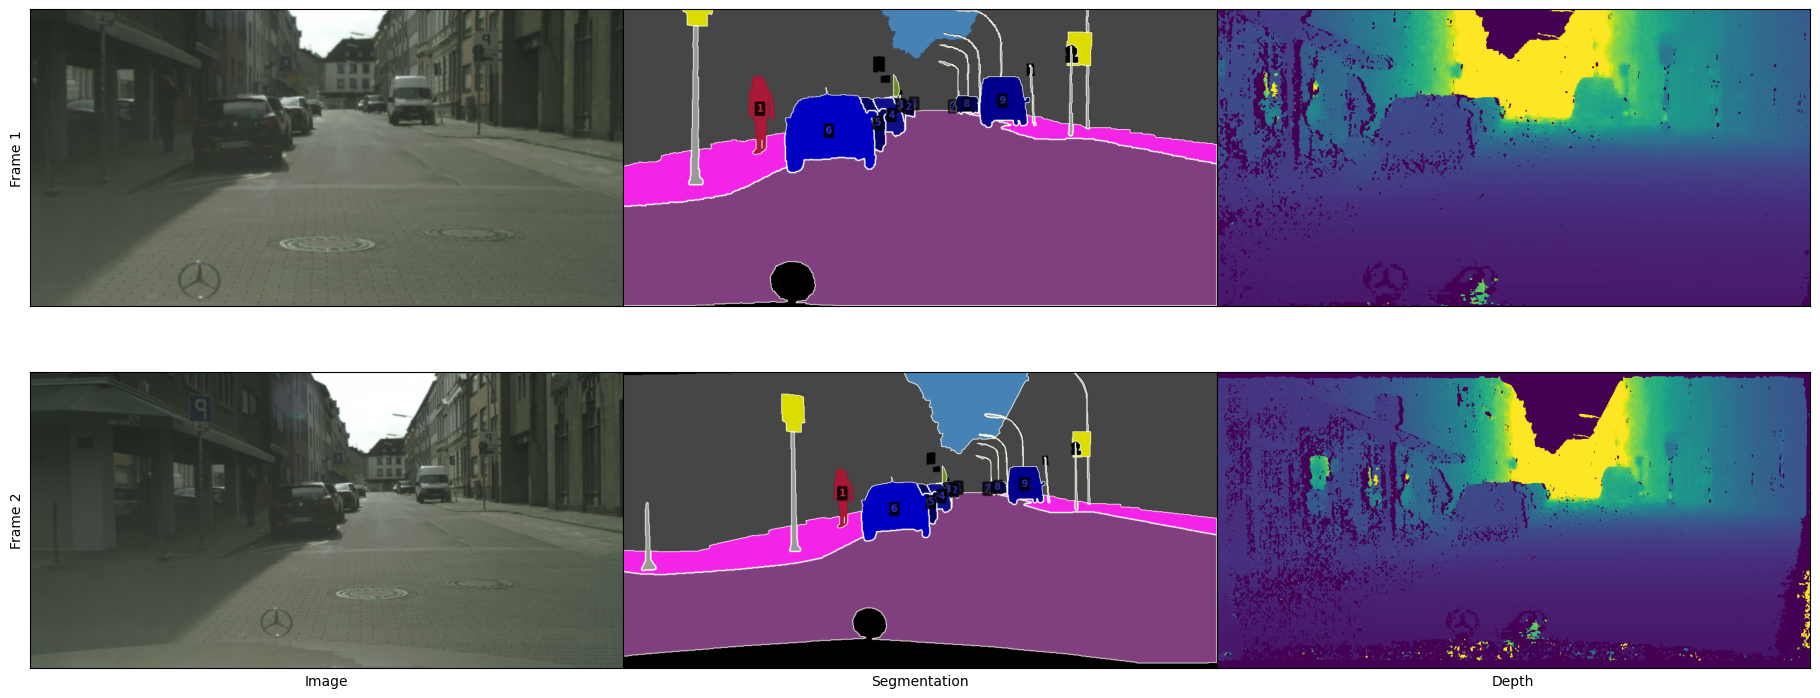

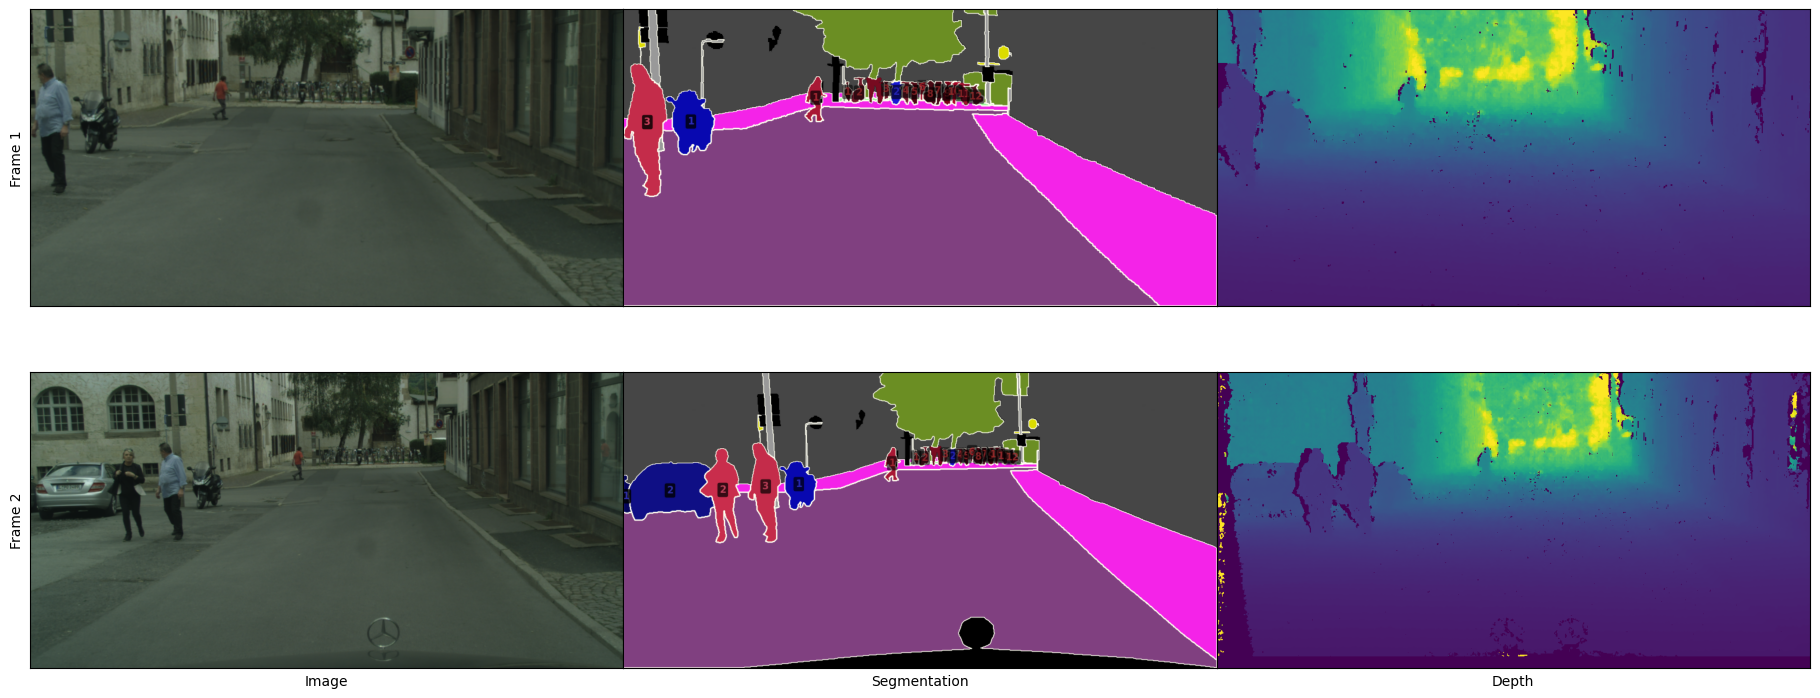

In [1]:
import os

import unipercept as up
import unimodels.multidvps as multidvps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
config = up.read_config('../configs/cityscapes/multidvps_resnet50.py')
dataset, info = up.prepare_dataset(config, "pretrain", return_loader=False)

for _ in range(3):
    inputs =next(dataset)
    up.render.utils.plot_input_data(inputs[0], info=info)
pass

In [2]:
model: multidvps.MultiDVPS = up.create_model(config)
print(model)

2023-11-23 16:50:43 📝 unipercept.trainer : Initializing Trainer: multidvps @ cityscapes/resnet50/2023-11-23_16-50-28@gcn34.local.snellius.surf.nl
2023-11-23 16:50:43 📝 unipercept.trainer : Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-23_16-50-28@gcn34.local.snellius.surf.nl


2023-11-23 16:50:43 📝 unipercept.trainer : Current process: 1 / 1
Could not recover model from training session: FileNotFoundError(2, 'No such file or directory')
MultiDVPS(
  (backbone): OptimizedModule(
    (_orig_mod): FeaturePyramidNetwork(
      (inner_blocks): ModuleList(
        (0): Sequential(
          (co2d): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (lncw): LayerNormCHW()
        )
        (1): Sequential(
          (co2d): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (lncw): LayerNormCHW()
        )
        (2): Sequential(
          (co2d): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (lncw): LayerNormCHW()
        )
        (3): Sequential(
          (co2d): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (lncw): LayerNormCHW()
        )
      )
      (layer_blocks): ModuleList(
        (0-3): 4 x Sequential(
          (se2d): Separable2d(
            (de

## Parameter count

We count the model parameters for each submodule.

In [3]:
def get_parameter_count(module: nn.Module) -> tuple[int,int]:
    """
    Returns the number of trainable and total (including non-trainable) parameters of a module.
    """
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    total = sum(p.numel() for p in module.parameters())
    return trainable, total

def make_human_readble(num: int) -> str:
    """
    Returns the integer in a human readable format, e.g. 1000 -> 1K, 1000000 -> 1M.
    """

    for unit in ["", "k"]:
        if abs(num) < 1000.0:
            return f"{num:.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} M"

def print_param_counts(mod: nn.Module, max_depth: int, *, cur_depth=0):
    """
    Prints the number of trainable and total (including non-trainable) parameters of a module and its submodules.
    """
    if cur_depth > max_depth:
        return
    trainable, total = get_parameter_count(mod)
    if total == 0:
        return
    indent = "    " * cur_depth
    name = indent + f"- {mod.__class__.__name__}"
    spacing = max(50 - len(name), 0) * " "
    print(f"{name}{spacing} : {make_human_readble(total):10s} -> {make_human_readble(trainable):10s}")
    for submod in mod.children():
        print_param_counts(submod, max_depth, cur_depth=cur_depth+1)

print_param_counts(model, 6)

- MultiDVPS                                        : 29.46 M    -> 5.95 M    
    - OptimizedModule                              : 24.37 M    -> 858.88 k  
        - FeaturePyramidNetwork                    : 24.37 M    -> 858.88 k  
            - ModuleList                           : 492.54 k   -> 492.54 k  
                - Sequential                       : 33.02 k    -> 33.02 k   
                    - Conv2d                       : 32.77 k    -> 32.77 k   
                    - LayerNormCHW                 : 256.00     -> 256.00    
                - Sequential                       : 65.79 k    -> 65.79 k   
                    - Conv2d                       : 65.54 k    -> 65.54 k   
                    - LayerNormCHW                 : 256.00     -> 256.00    
                - Sequential                       : 131.33 k   -> 131.33 k  
                    - Conv2d                       : 131.07 k   -> 131.07 k  
                    - LayerNormCHW                 : 256.00     

To ensure compatability with specialized optimizers, e.g. fused adam, we list the unique parameter datatypes below.

In [4]:
unique_param_dtypes = set()
for name, param in model.cuda().named_parameters():
    unique_param_dtypes.add(param.dtype)

print(f"Unique parameter dtypes: {unique_param_dtypes}")

Unique parameter dtypes: {torch.float32}


## Training forward pass

In [5]:
inputs = inputs.cuda()
model.cuda().train()

print("benchmarking")
%timeit model(inputs)
print("benchmarking again to avoid caching")
%timeit model(inputs)
# model_cmp = torch.compile(model, backend="cudagraphs")

# print("benchmarking")
# %timeit model_cmp(inputs)

# ctx = model._forward_common(inputs.cuda())
# print(ctx)

benchmarking


/home/kstolle/projects/unipercept/venv/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/kstolle/projects/unipercept/venv/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/kstolle/projects/unipercept/venv/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/kstolle/projects/unipercept/venv/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [ ]:
truths = model.training_pipeline.true_segmentation(ctx)

print(truths)

NameError: name 'ctx' is not defined

fpn.3
fpn.3
fpn.4
fpn.4
fpn.5
fpn.5
fpn.6
fpn.6


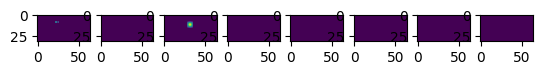

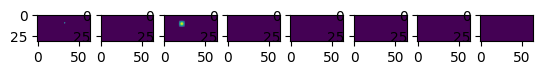

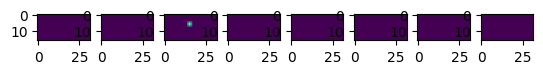

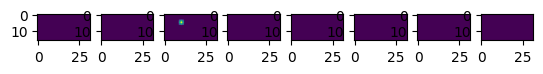

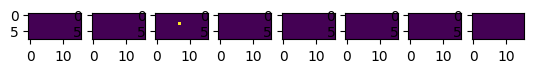

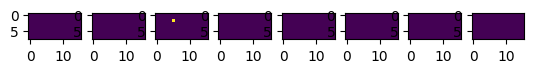

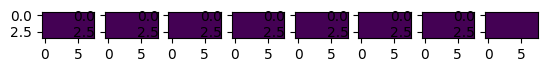

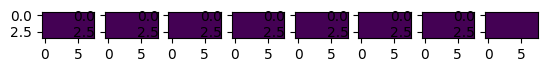

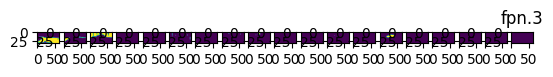

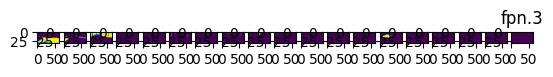

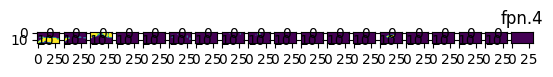

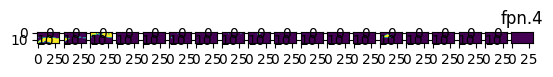

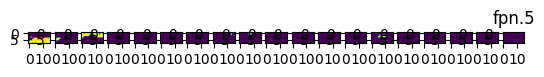

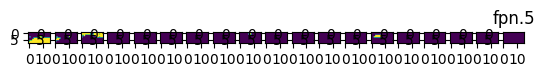

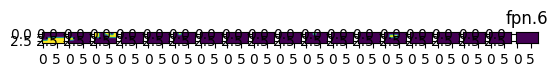

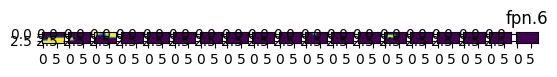

In [ ]:
for level, things in truths.thing.items():
    for things in things:
        print(level)
        
        fig, ax = plt.subplots(1, things.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(things.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
for level, stuff in truths.stuff.items():
    for stuff in stuff:
        fig, ax = plt.subplots(1, stuff.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(stuff.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
        plt.title(level)

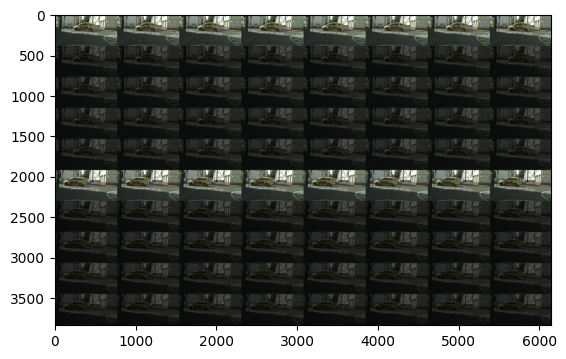

In [ ]:
vis = multidvps.visuals.visualize_true_things(ctx.captures.images, list(truths.thing.values()))
plt.imshow(vis.permute(1,2,0) / 255)

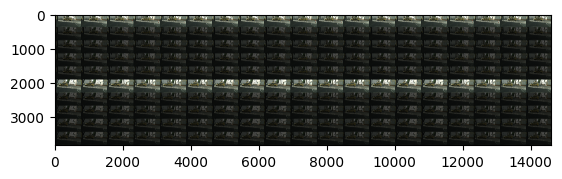

In [ ]:
vis = multidvps.visuals.visualize_true_stuff(ctx.captures.images, list(truths.stuff.values()))

plt.imshow(vis.permute(1,2,0) / vis.max())